<a href="https://colab.research.google.com/github/Lexaun-chen/STAT-4830-Group-Project/blob/main/notebooks/Matrix_Completion_with_SGD_and_NQM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [1]:
class MF():

    def __init__(self, X, k, alpha, beta, iterations):
        """
        Perform matrix factorization to predict np.nan entries in a matrix.
        Arguments
        - X (ndarray)   : sample-feature matrix
        - k (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """

        self.X = X
        self.num_samples, self.num_features = X.shape
        self.k = k
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        # True if not nan
        self.not_nan_index = (np.isnan(self.X) == False)

    def train(self):
        # Initialize factorization matrix U and V
        self.U = np.random.normal(scale=1./self.k, size=(self.num_samples, self.k))
        self.V = np.random.normal(scale=1./self.k, size=(self.num_features, self.k))

        # Initialize the biases
        self.b_u = np.zeros(self.num_samples)
        self.b_v = np.zeros(self.num_features)
        self.b = np.mean(self.X[np.where(self.not_nan_index)])
        # Create a list of training samples
        self.samples = [
            (i, j, self.X[i, j])
            for i in range(self.num_samples)
            for j in range(self.num_features)
            if not np.isnan(self.X[i, j])
        ]

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            # total square error
            se = self.square_error()
            training_process.append((i, se))
            if (i+1) % 20 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, se))

        return training_process

    def square_error(self):
        """
        A function to compute the total square error
        """
        predicted = self.full_matrix()
        error = 0
        for i in range(self.num_samples):
            for j in range(self.num_features):
                if self.not_nan_index[i, j]:
                    error += pow(self.X[i, j] - predicted[i, j], 2)
        return error

    def sgd(self):
        """
        Perform stochastic graident descent(SGD)
        """
        for i, j, x in self.samples:
            # Computer prediction and error
            prediction = self.get_x(i, j)
            e = (x - prediction)

            # Update biases
            self.b_u[i] += self.alpha * (2 * e - self.beta * self.b_u[i])
            self.b_v[j] += self.alpha * (2 * e - self.beta * self.b_v[j])

            # Update factorization matrix U and V
            """
            If RuntimeWarning: overflow encountered in multiply,
            then turn down the learning rate alpha.
            """
            self.U[i, :] += self.alpha * (2 * e * self.V[j, :] - self.beta * self.U[i,:])
            self.V[j, :] += self.alpha * (2 * e * self.U[i, :] - self.beta * self.V[j,:])

    def get_x(self, i, j):
        """
        Get the predicted x of sample i and feature j
        """
        prediction = self.b + self.b_u[i] + self.b_v[j] + self.U[i, :].dot(self.V[j, :].T)
        return prediction

    def full_matrix(self):
        """
        Compute the full matrix using the resultant biases, U and V
        """
        return self.b + self.b_u[:, np.newaxis] + self.b_v[np.newaxis, :] + self.U.dot(self.V.T)

    def replace_nan(self, X_hat):
        """
        Replace np.nan of X with the corresponding value of X_hat
        """
        X = np.copy(self.X)
        for i in range(self.num_samples):
            for j in range(self.num_features):
                if np.isnan(X[i, j]):
                    X[i, j] = X_hat[i, j]
        return X


In [15]:
class MF_NQM:
    def __init__(self, X, k, alpha=1e-4, beta=0.01, iterations=100,
                 noise_var=1e-6, momentum=0.8, ema_beta=0.9, update_strategy='vanilla'):
        self.X = X
        self.num_samples, self.num_features = X.shape
        self.k = k
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.noise_var = noise_var
        self.momentum = momentum
        self.ema_beta = ema_beta
        self.update_strategy = update_strategy.lower()

        assert self.update_strategy in ['vanilla', 'momentum', 'ema']

        self.not_nan_index = ~np.isnan(X)

        self.U = np.random.normal(scale=0.005, size=(self.num_samples, self.k))
        self.V = np.random.normal(scale=0.005, size=(self.num_features, self.k))
        self.b_u = np.zeros(self.num_samples)
        self.b_v = np.zeros(self.num_features)
        self.b = np.nanmean(X)

        self.U_momentum = np.zeros_like(self.U)
        self.V_momentum = np.zeros_like(self.V)
        self.U_ema = np.zeros_like(self.U)
        self.V_ema = np.zeros_like(self.V)

        self.samples = [
            (i, j, X[i, j])
            for i in range(self.num_samples)
            for j in range(self.num_features)
            if not np.isnan(X[i, j])
        ]

    def train(self):
        training_process = []
        for it in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            error = self.square_error()
            training_process.append((it, error))
            if (it + 1) % 10 == 0:
                print(f"Iteration {it+1}/{self.iterations} ; Error = {error:.4f}")
        return training_process

    def sgd(self):
        max_grad = 1.0
        param_bound = 10.0

        for i, j, x in self.samples:
            pred = self.get_x(i, j)
            e = x - pred

            grad_U = 2 * e * self.V[j, :] - self.beta * self.U[i, :]
            grad_V = 2 * e * self.U[i, :] - self.beta * self.V[j, :]

            grad_U = np.clip(grad_U, -max_grad, max_grad)
            grad_V = np.clip(grad_V, -max_grad, max_grad)

            self.b_u[i] += self.alpha * (2 * e - self.beta * self.b_u[i])
            self.b_v[j] += self.alpha * (2 * e - self.beta * self.b_v[j])

            noise_u = np.random.normal(0, np.sqrt(self.noise_var), size=self.k)
            noise_v = np.random.normal(0, np.sqrt(self.noise_var), size=self.k)

            if self.update_strategy == 'vanilla':
                self.U[i, :] += self.alpha * grad_U + noise_u
                self.V[j, :] += self.alpha * grad_V + noise_v

            elif self.update_strategy == 'momentum':
                self.U_momentum[i, :] = self.momentum * self.U_momentum[i, :] + self.alpha * grad_U
                self.V_momentum[j, :] = self.momentum * self.V_momentum[j, :] + self.alpha * grad_V
                self.U[i, :] += self.U_momentum[i, :] + noise_u
                self.V[j, :] += self.V_momentum[j, :] + noise_v

            elif self.update_strategy == 'ema':
                self.U_ema[i, :] = self.ema_beta * self.U_ema[i, :] + (1 - self.ema_beta) * grad_U
                self.V_ema[j, :] = self.ema_beta * self.V_ema[j, :] + (1 - self.ema_beta) * grad_V
                self.U[i, :] += self.U_ema[i, :] + noise_u
                self.V[j, :] += self.V_ema[j, :] + noise_v

            self.U[i, :] = np.clip(self.U[i, :], -param_bound, param_bound)
            self.V[j, :] = np.clip(self.V[j, :], -param_bound, param_bound)

            if np.isnan(e) or np.any(np.isnan(self.U[i, :])) or np.any(np.isnan(self.V[j, :])):
                print("NaN detected in training, stopping early")
                break

    def get_x(self, i, j):
        return self.b + self.b_u[i] + self.b_v[j] + self.U[i, :].dot(self.V[j, :].T)

    def full_matrix(self):
        return self.b + self.b_u[:, np.newaxis] + self.b_v[np.newaxis, :] + self.U.dot(self.V.T)

    def replace_nan(self, X_hat):
        X_copy = np.copy(self.X)
        X_copy[np.isnan(X_copy)] = X_hat[np.isnan(X_copy)]
        return X_copy

    def square_error(self):
        pred = self.full_matrix()
        return ((self.X - pred)**2)[self.not_nan_index].mean()


In [17]:
def train_multiple_strategies(X_scaled, k, iterations, strategy_configs):
    results = {}
    for strategy, config in strategy_configs.items():
        print(f"\nTraining strategy: {strategy}")
        model = MF_NQM(
            X_scaled, k=k,
            alpha=config.get("alpha", 1e-4),
            beta=config.get("beta", 0.01),
            iterations=iterations,
            noise_var=config.get("noise_var", 1e-6),
            momentum=config.get("momentum", 0.8),
            ema_beta=config.get("ema_beta", 0.9),
            update_strategy=strategy
        )
        history = model.train()
        results[strategy] = {"history": history, "model": model}
    return results

In [23]:
def summarize_results(results, X_original, scaled=True):
    print("\nSummary of Final Errors and Completed Matrices:")
    records = []
    for strategy, data in results.items():
        model = data["model"]
        X_hat_scaled = model.full_matrix()
        X_comp_scaled = model.replace_nan(X_hat_scaled)

        if scaled:
            X_hat = X_hat_scaled * np.nanmax(X_original)
            X_comp = X_comp_scaled * np.nanmax(X_original)
        else:
            X_hat = X_hat_scaled
            X_comp = X_comp_scaled

        true_vals = X_original[model.not_nan_index]
        pred_vals = X_hat[model.not_nan_index]

        mse = mean_squared_error(true_vals, pred_vals)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(true_vals, pred_vals)

        records.append({
            "Strategy": strategy,
            "MSE": round(mse, 4),
            "RMSE": round(rmse, 4),
            "MAE": round(mae, 4)
        })

        print(f"\n[{strategy.upper()}] Completed Matrix:")
        print(np.round(X_comp, 2))

    df = pd.DataFrame(records)
    print("\nError Comparison Table:")
    print(df.to_string(index=False))
    return df

def plot_error_bars(df):
    df.plot(x='Strategy', y=['MSE', 'RMSE', 'MAE'], kind='bar')
    plt.title("Final Error Comparison")
    plt.ylabel("Error Value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Original Matrix (with Nans):
[[ 5.  3. nan  1.  4.]
 [ 4. nan nan  1.  2.]
 [ 1.  1. nan  5. nan]
 [ 1. nan nan  4.  4.]
 [nan  1.  5.  4. nan]
 [nan  2.  4. nan  5.]]

Scaled Matrix (with Nans):
[[1.  0.6 nan 0.2 0.8]
 [0.8 nan nan 0.2 0.4]
 [0.2 0.2 nan 1.  nan]
 [0.2 nan nan 0.8 0.8]
 [nan 0.2 1.  0.8 nan]
 [nan 0.4 0.8 nan 1. ]] 

Iteration: 20 ; error = 1.3853
Iteration: 40 ; error = 1.1337
Iteration: 60 ; error = 1.0233
Iteration: 80 ; error = 0.9312
Iteration: 100 ; error = 0.8320
Iteration: 120 ; error = 0.7209
Iteration: 140 ; error = 0.6038
Iteration: 160 ; error = 0.4921
Iteration: 180 ; error = 0.3954
Iteration: 200 ; error = 0.3178
Iteration: 220 ; error = 0.2580
Iteration: 240 ; error = 0.2130
Iteration: 260 ; error = 0.1792
Iteration: 280 ; error = 0.1537
Iteration: 300 ; error = 0.1347

SGD Predicted Matrix (X_hat):
[[4.81749663 2.2719136  4.09657776 1.90026102 3.96827902]
 [3.60893377 0.37125028 3.34356152 1.13069911 2.35422627]
 [1.32267625 0.99179707 3.68169375 4.65

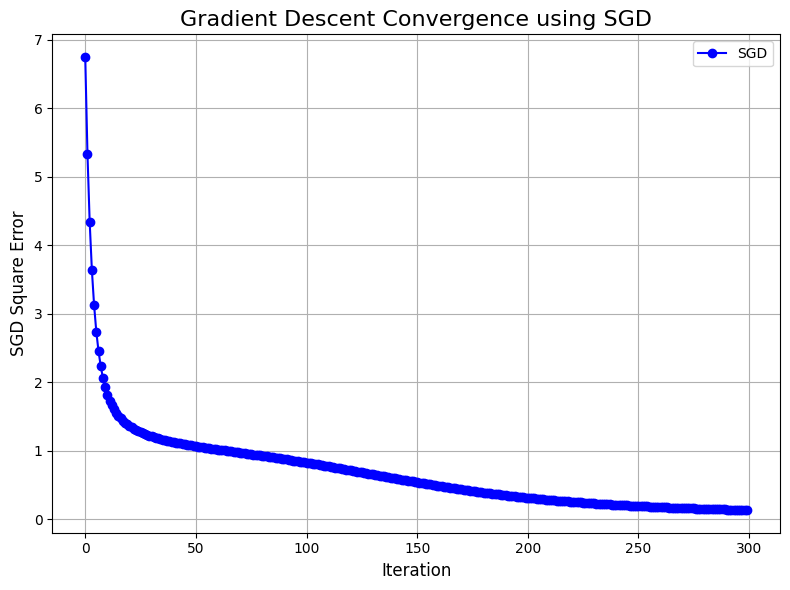


Training strategy: vanilla
Iteration 10/300 ; Error = 0.0987
Iteration 20/300 ; Error = 0.0965
Iteration 30/300 ; Error = 0.0945
Iteration 40/300 ; Error = 0.0925
Iteration 50/300 ; Error = 0.0907
Iteration 60/300 ; Error = 0.0890
Iteration 70/300 ; Error = 0.0874
Iteration 80/300 ; Error = 0.0860
Iteration 90/300 ; Error = 0.0847
Iteration 100/300 ; Error = 0.0835
Iteration 110/300 ; Error = 0.0823
Iteration 120/300 ; Error = 0.0813
Iteration 130/300 ; Error = 0.0802
Iteration 140/300 ; Error = 0.0794
Iteration 150/300 ; Error = 0.0785
Iteration 160/300 ; Error = 0.0776
Iteration 170/300 ; Error = 0.0768
Iteration 180/300 ; Error = 0.0761
Iteration 190/300 ; Error = 0.0754
Iteration 200/300 ; Error = 0.0747
Iteration 210/300 ; Error = 0.0741
Iteration 220/300 ; Error = 0.0735
Iteration 230/300 ; Error = 0.0729
Iteration 240/300 ; Error = 0.0724
Iteration 250/300 ; Error = 0.0719
Iteration 260/300 ; Error = 0.0715
Iteration 270/300 ; Error = 0.0709
Iteration 280/300 ; Error = 0.0705
I

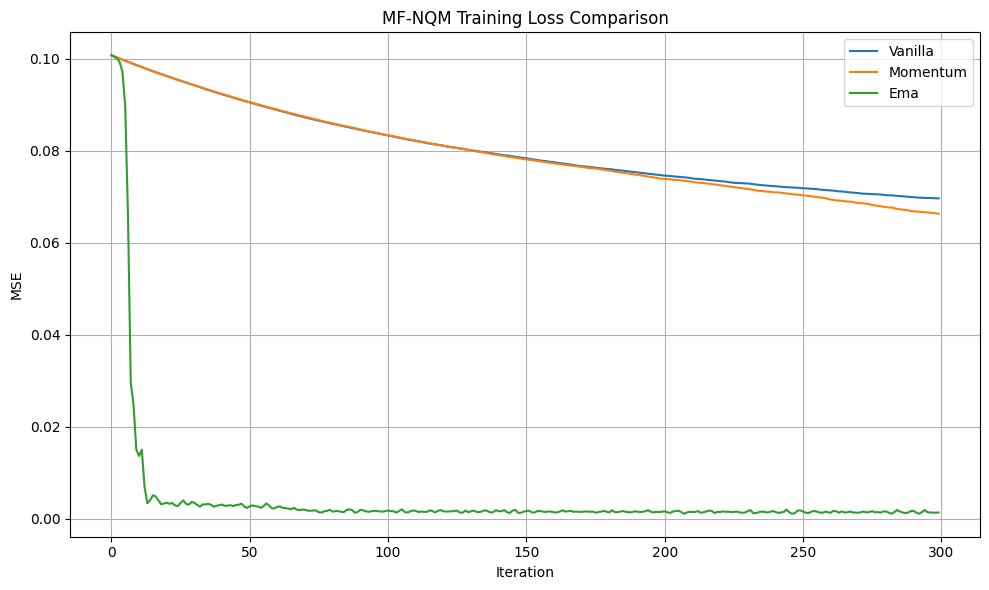

In [27]:
if __name__ == '__main__':
    X = np.array([
          [5, 3, 0, 1, 4],
          [4, 0, 0, 1, 2],
          [1, 1, 0, 5, 0],
          [1, 0, 0, 4, 4],
          [0, 1, 5, 4, 0],
          [0, 2, 4, 0, 5]
      ], dtype=float)

    # Replace 0 with np.nan
    X[X == 0] = np.nan

    # Scale the data to the range [0, 1] for the non-nan values
    X_scaled = X / np.nanmax(X)

    print("\nOriginal Matrix (with Nans):")
    print(X)

    print("\nScaled Matrix (with Nans):")
    print(X_scaled,"\n")

    np.random.seed(1)


#1. Use SGD
    mf_sgd = MF(X_scaled, k=2, alpha=0.01, beta=0.1, iterations=300)
    sgd_training_process = mf_sgd.train()

    # Unscale the predicted matrix to the original scale
    sgd_X_hat_scaled = mf_sgd.full_matrix()

    sgd_X_comp_scaled = mf_sgd.replace_nan(sgd_X_hat_scaled)
    sgd_X_comp = sgd_X_comp_scaled * np.nanmax(X)
    sgd_X_hat = sgd_X_hat_scaled * np.nanmax(X)

    print("\nSGD Predicted Matrix (X_hat):")
    print(sgd_X_hat)
    print("\nSGD Completed Matrix (X_comp):")
    print(sgd_X_comp)

    # Plot the error over iterations
    sgd_iterations, sgd_errors = zip(*sgd_training_process)

    plt.figure(figsize=(8, 6))
    plt.plot(sgd_iterations, sgd_errors, marker='o', linestyle='-', color='b', label='SGD')
    plt.title('Gradient Descent Convergence using SGD', fontsize=16)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('SGD Square Error', fontsize=12)

    plt.grid(True)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()



#2. Combine NQM
    strategy_configs = {
        "vanilla": {"alpha": 5e-4, "beta": 0.05, "noise_var": 1e-6},
        "momentum": {"alpha": 5e-4, "beta": 0.05, "noise_var": 1e-6, "momentum": 0.9},
        "ema": {"alpha": 5e-4, "beta": 0.05, "noise_var": 1e-6, "ema_beta": 0.9}
    }

    results = train_multiple_strategies(X_scaled, k=3, iterations=300, strategy_configs=strategy_configs)

    plt.figure(figsize=(10, 6))
    for strategy, result in results.items():
        iters, errors = zip(*result["history"])
        plt.plot(iters, errors, label=strategy.capitalize())
    plt.xlabel("Iteration")
    plt.ylabel("MSE")
    plt.title("MF-NQM Training Loss Comparison")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()




Summary of Final Errors and Completed Matrices:

[VANILLA] Completed Matrix:
[[5.   3.   3.81 1.   4.  ]
 [4.   1.63 3.14 1.   2.  ]
 [1.   1.   3.33 5.   3.25]
 [1.   2.03 3.54 4.   4.  ]
 [3.12 1.   5.   4.   3.73]
 [3.25 2.   4.   3.41 5.  ]]

[MOMENTUM] Completed Matrix:
[[5.   3.   3.81 1.   4.  ]
 [4.   1.62 3.13 1.   2.  ]
 [1.   1.   3.34 5.   3.28]
 [1.   2.03 3.55 4.   4.  ]
 [3.08 1.   5.   4.   3.74]
 [3.27 2.   4.   3.4  5.  ]]

[EMA] Completed Matrix:
[[5.   3.   2.81 1.   4.  ]
 [4.   3.73 1.68 1.   2.  ]
 [1.   1.   4.69 5.   3.99]
 [1.   1.8  3.85 4.   4.  ]
 [2.09 1.   5.   4.   4.41]
 [2.93 2.   4.   3.15 5.  ]]

Error Comparison Table:
Strategy    MSE   RMSE    MAE
 vanilla 1.7424 1.3200 1.1649
momentum 1.6582 1.2877 1.1396
     ema 0.0347 0.1864 0.1575


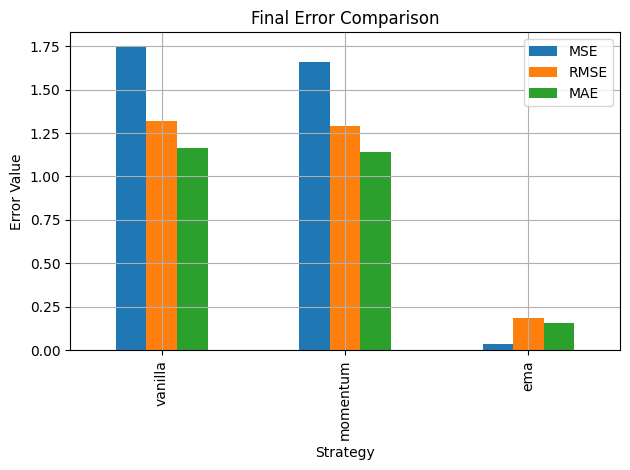

In [28]:
    df = summarize_results(results, X_original=X, scaled=True)
    plot_error_bars(df)


Generated matrix completion dataset: 500 x 500, rank 10, 60.0% observed entries
Iteration: 20 ; error = 1523.2719
Iteration: 40 ; error = 1247.5792
Iteration: 60 ; error = 1159.2583
Iteration: 80 ; error = 1133.0626
Iteration: 100 ; error = 1123.5261
Iteration: 120 ; error = 1120.5677
Iteration: 140 ; error = 1118.4434
Iteration: 160 ; error = 1117.9599
Iteration: 180 ; error = 1117.2988
Iteration: 200 ; error = 1116.5091
Iteration: 220 ; error = 1115.7817
Iteration: 240 ; error = 1115.5560
Iteration: 260 ; error = 1115.8952
Iteration: 280 ; error = 1116.2644
Iteration: 300 ; error = 1116.1359


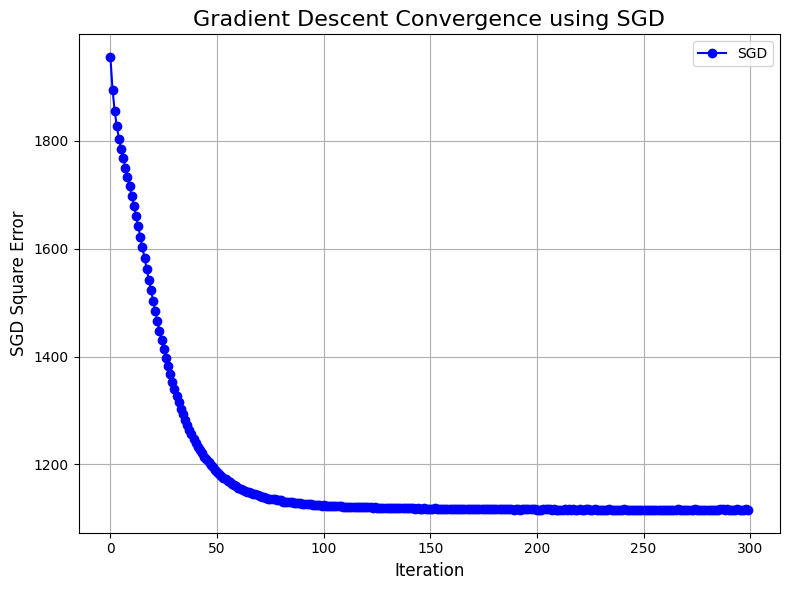


Training strategy: vanilla
Iteration 10/300 ; Error = 0.0401
Iteration 20/300 ; Error = 0.0399
Iteration 30/300 ; Error = 0.0399
Iteration 40/300 ; Error = 0.0400
Iteration 50/300 ; Error = 0.0400
Iteration 60/300 ; Error = 0.0400
Iteration 70/300 ; Error = 0.0400
Iteration 80/300 ; Error = 0.0400
Iteration 90/300 ; Error = 0.0399
Iteration 100/300 ; Error = 0.0399
Iteration 110/300 ; Error = 0.0399
Iteration 120/300 ; Error = 0.0399
Iteration 130/300 ; Error = 0.0399
Iteration 140/300 ; Error = 0.0398
Iteration 150/300 ; Error = 0.0398
Iteration 160/300 ; Error = 0.0398
Iteration 170/300 ; Error = 0.0397
Iteration 180/300 ; Error = 0.0397
Iteration 190/300 ; Error = 0.0397
Iteration 200/300 ; Error = 0.0396
Iteration 210/300 ; Error = 0.0396
Iteration 220/300 ; Error = 0.0395
Iteration 230/300 ; Error = 0.0395
Iteration 240/300 ; Error = 0.0394
Iteration 250/300 ; Error = 0.0393
Iteration 260/300 ; Error = 0.0393
Iteration 270/300 ; Error = 0.0392
Iteration 280/300 ; Error = 0.0391
I

In [ ]:
# Data set generation for large-scale matrix completion task

if __name__ == "__main__":

    np.random.seed(1)

    # Define matrix dimensions and rank
    n1, n2, r = 500, 500, 10  # Generate a 100x100 low-rank matrix with rank 3

    # Generate a low-rank matrix M
    M = np.random.randn(n1, r) @ np.random.randn(r, n2)

    # Compute degrees of freedom and determine the number of observed values
    df = r * (n1 + n2 - r)
    m = min(6 * df, round(0.2 * n1 * n2))  # Select 20% of entries as observed data
    p = 3 * m / (n1 * n2)  # Observation rate

    # Randomly select observed indices
    Omega = np.random.choice(n1 * n2, m, replace=False)
    data = M.flatten()[Omega]

    # Optional: Add noise to simulate real-world data
    sigma_noise = 1e-6  # Noise variance
    data += sigma_noise * np.random.randn(*data.shape)

    # Create the incomplete matrix X with missing values
    X = np.full((n1, n2), np.nan)
    X.flat[Omega] = data

    print(f"\nGenerated matrix completion dataset: {n1} x {n2}, rank {r}, {100 * p:.1f}% observed entries")

    # Scale the data to the range [0, 1] for the non-nan values
    X_scaled = X / np.nanmax(X)

    # print("\nOriginal Matrix (with Nans):")
    # print(X)

    # print("\nScaled Matrix (with Nans):")
    # print(X_scaled, "\n")

    np.random.seed(1)


    #1. Apply SGD
    mf_sgd = MF(X_scaled, k=10, alpha=0.01, beta=0.1, iterations=300)
    sgd_training_process = mf_sgd.train()

    # Unscale the predicted matrix to the original scale
    sgd_X_hat_scaled = mf_sgd.full_matrix()

    sgd_X_comp_scaled = mf_sgd.replace_nan(sgd_X_hat_scaled)
    sgd_X_comp = sgd_X_comp_scaled * np.nanmax(X)
    sgd_X_hat = sgd_X_hat_scaled * np.nanmax(X)

    # print("\nSGD Predicted Matrix (X_hat):")
    # print(sgd_X_hat)
    # print("\nSGD Completed Matrix (X_comp):")
    # print(sgd_X_comp)

    # Plot the error over iterations
    sgd_iterations, sgd_errors = zip(*sgd_training_process)

    plt.figure(figsize=(8, 6))
    plt.plot(sgd_iterations, sgd_errors, marker='o', linestyle='-', color='b', label='SGD')
    plt.title('Gradient Descent Convergence using SGD', fontsize=16)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('SGD Square Error', fontsize=12)

    plt.grid(True)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()



    # 2. Apply NQM-based Matrix Factorization

    strategy_configs = {
        "vanilla": {"alpha": 5e-4, "beta": 0.05, "noise_var": 1e-6},
        "momentum": {"alpha": 5e-4, "beta": 0.05, "noise_var": 1e-6, "momentum": 0.9},
        "ema": {"alpha": 5e-4, "beta": 0.05, "noise_var": 1e-6, "ema_beta": 0.9}
    }

    results = train_multiple_strategies(X_scaled, k=10, iterations=300, strategy_configs=strategy_configs)

    plt.figure(figsize=(10, 6))
    for strategy, result in results.items():
        iters, errors = zip(*result["history"])
        plt.plot(iters, errors, label=strategy.capitalize())
    plt.xlabel("Iteration")
    plt.ylabel("MSE")
    plt.title("MF-NQM Training Loss Comparison (Large Scale)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    df = summarize_results(results, X_original=X, scaled=True)
    plot_error_bars(df)
